Notebook to import data from Google Trends given CSV files and scale them and perform ANOVA (and eventually Tukey HSD) analysis. 

## Part 1: Statistical Analysis

In [51]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from matplotlib import pyplot as plt

Here, I'm going to use pandas to import data from all CSVs that i tell it to import data from into a pandas dataframe

In [52]:
files = ["EuroHis", "ComputerScience", "WorldHistoryModern", "EnglishLanguageAndComposition", "Biology", "Chemistry", "Physics", "Micro", "Macro", "MusicTheory", "Statistics", "USHis", "Psych", "HumanGeo", "USGov"]
print(len(files))
data = []
scaler = preprocessing.MinMaxScaler()
for name in files: 
    i = files.index(name)
    full_rel_path = "raw-datasets/" + name + ".csv"
    data.append(pd.read_csv(full_rel_path, sep=",", header=None, skiprows=3)) # First 3 rows have headers that I don't want
    data[i] = data[i].drop(data[i].columns[0], axis=1)
    data[i] = data[i].replace('<1', '1')
    data[i].columns = ['AP ' + name + ' interest', name + ' interest']
    data[i]['AP ' + name + ' interest'] = pd.to_numeric(data[i]['AP ' + name + ' interest'],errors='coerce')
    data[i][name + ' interest'] = pd.to_numeric(data[i][name + ' interest'],errors='coerce')
    data[i] = data[i] / 100

15


The above exporting of the scaled dataset is occuring just to backup data in case of failure

In [53]:
dev_stats = []
for df in data: 
    ap_diff = []
    field_diff = []
    ap_mean = df[df.columns[0]].mean()
    field_mean = df[df.columns[1]].mean()
    for index, row in df.iterrows(): 
        ap_interest = row[df.columns[0]]
        field_interest = row[df.columns[1]]
        ap_diff.append((ap_mean - ap_interest) ** 2) # must be squared because the negative and positive versions cause issues. 
        field_diff.append((field_mean - field_interest)**2)
        ap_diff.append(ap_interest)
        field_diff.append(field_interest)
    dev_stats.append(pd.DataFrame(list(zip(ap_diff, field_diff)),columns =['AP Interest DEV Stat', 'Field DEV Stat']))

The above cell takes all of the data processed, calculated the DEV stat, and adds it to the dataframe

In [56]:
ap_input = []
field_input = []
for df in dev_stats:
    ap_input.append(np.array(df[df.columns[0]]))
    field_input.append(np.array(df[df.columns[1]]))
print(scipy.stats.f_oneway(ap_input[0], ap_input[1],ap_input[2], ap_input[3],ap_input[4], ap_input[5], ap_input[6], ap_input[7], ap_input[8], ap_input[9], ap_input[10], ap_input[11], ap_input[12], ap_input[13], ap_input[14]))
print(scipy.stats.f_oneway(field_input[0], field_input[1], field_input[2], field_input[3], field_input[4], field_input[5], field_input[6], field_input[7], field_input[8], field_input[9], field_input[10], field_input[11], field_input[12], field_input[13], field_input[14]))
df_ap = pd.DataFrame()
for i in range(len(files)):
    df_ap["AP " + files[i]] = ap_input[i]
stacked_data = df_ap.stack().reset_index()
stacked_data = stacked_data.rename(columns={'level_0': 'id',
                                            'level_1': 'AP Test',
                                            0:'DEV Stat'})
MultiComp = MultiComparison(stacked_data['DEV Stat'],
                            stacked_data['AP Test'])
Results = MultiComp.tukeyhsd()
tukeysresults = pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])
tukeysresults.to_excel("tukeys_ap.xlsx")

df_field = pd.DataFrame()
for i in range(len(files)):
    df_field["AP " + files[i]] = field_input[i]
stacked_data = df_ap.stack().reset_index()
stacked_data = stacked_data.rename(columns={'level_0': 'id',
                                            'level_1': 'Field',
                                            0:'DEV Stat'})
MultiComp = MultiComparison(stacked_data['DEV Stat'],
                            stacked_data['Field'])
Results = MultiComp.tukeyhsd()
tukeysresults = pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])
tukeysresults.to_excel("tukeys_field.xlsx")

F_onewayResult(statistic=121.50004946959376, pvalue=8.430541912632e-311)
F_onewayResult(statistic=67.80006283710388, pvalue=6.970772740386602e-179)


This above cell is able to take the data and run ANOVA and Tukey's HSD

## Part 2: Machine Learning 🤗

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class PredictionModel(nn.Module):
    """Dynamically created PredictionModel based off of inputted parameters for layers"""
    def __init__(self, layers):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        super(PredictionModel, self).__init__()
        modules = []
        for layer in layers:
            modules.append(nn.Linear(layer[0], layer[1]))
            modules.append(nn.LeakyReLU())
        modules.pop()
        self.runModel = nn.Sequential(*modules).to(device)
    def forward(self, x):
        pred = self.runModel(x)
        return pred
    def getDevice(self):
        return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

390


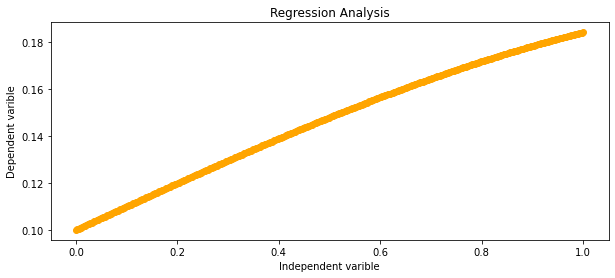

Epoch:  99 Loss:  0.003189168870449066
Epoch:  199 Loss:  0.0004495646571740508
Epoch:  299 Loss:  0.000260025990428403
Epoch:  399 Loss:  0.0002055216464214027


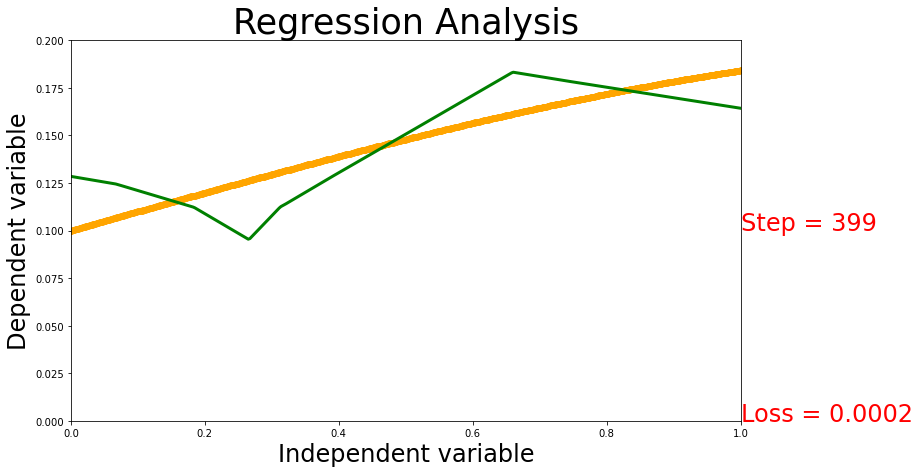

In [58]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
from livelossplot import PlotLosses
from shutil import copyfile

z1 = list(np.linspace(0,1,390))
print(len(z1))
y1 = np.array(list(map(lambda x: [0.1*np.sin(x) + 0.1], z1)))
x1 = np.array(list(map(lambda x: [x], z1)))
x = Variable(torch.from_numpy(x1)).to(torch.float).to("cpu") # months after the first date, repeated per subject
y = Variable(torch.from_numpy(y1)).to(torch.float).to("cpu") # months after the first date, repeated per subject
x, y = Variable(x), Variable(y)
# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()

net = PredictionModel([[1,200],[200,100],[100,1]])
optimizer = torch.optim.Adam(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
resuming = False
torch.manual_seed(1)    # reproducible

if os.path.isfile('models/interim_model.tar'):
    resuming = True
    checkpoint = torch.load('models/interim_model.tar')
    print(checkpoint.keys())
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss1 = checkpoint['loss']
my_images = []
fig, ax = plt.subplots(figsize=(12,7))
logs = {}
liveloss = PlotLosses()
for t in range(400):
    if resuming:
        it = epoch + t
        loss = loss1
    else: 
        it = t
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if it % 100 == 99:
        print("Epoch: ", t, "Loss: ", loss.item())
    # plot and show learning process
    torch.save({
        'epoch': it,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, "models/interim_model.tar")
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('Independent variable', fontsize=24)
    ax.set_ylabel('Dependent variable', fontsize=24)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.2)
    ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
    ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
            fontdict={'size': 24, 'color':  'red'})
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    
copyfile("models/interim_model.tar", "models/final_model.tar")
# save images as a gif    
imageio.mimsave('./curve_1.gif', my_images, fps=10)